# 1. Import

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cdlib import viz
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
import networkx as nx
from cdlib import algorithms, viz

## 1.1 Importing data

In [18]:
# load data from tsv file to a pandas dataframe
movies_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None)

The columns have the following labels:
<br> Movies metadata:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

Character/actors metadata:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

Plot summaries:
1. Wikipedia movie ID
2. Plot summary

In [19]:
#label the columns
movies_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres'] 
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender', 'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']
plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']

## 1.2 Visualizing row data

In [20]:
movies_metadata.sample(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
68390,12662464,/m/02w_frw,Garibaldi,NaN,NaN,106.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/07s9rl0"": ""Drama""}"
2486,17792184,/m/047cvb7,Engine Trouble,NaN,NaN,NaN,{},"{""/m/0154j"": ""Belgium""}","{""/m/02hmvc"": ""Short Film"", ""/m/01hmnh"": ""Fant..."
50940,26357599,/m/0bbw_x_,Six in Paris,1965,NaN,95.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/07s9rl0"": ""Drama"", ""/m/02n4lw"": ""Art film..."


In [21]:
character_metadata.sample(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
73951,13027958,/m/02z3xy1,2005-07-02,Woman at Mall,NaN,F,NaN,NaN,Valerie Howell,NaN,/m/0jwg06h,/m/0jwg06l,/m/0jwg06t
56950,22832896,/m/0640k56,2009-05-18,Dog trainer,1981-02-22,M,NaN,NaN,Alexander Voulgaris,28.0,/m/0byfp10,/m/0h5sqqd,/m/0byfp0t
386197,1296905,/m/04qtq9,1942,NaN,1906-08-12,M,NaN,NaN,Tedd Pierce,35.0,/m/052bm2x,NaN,/m/056fjf


In [22]:
plot_summaries.sample(3)

,Wikipedia_movie_ID,Plot_summary
16036,3788150,{{cleanup}} Emory Leeson is an advertising exe...
13643,31361927,Sreenu is the son of Vishwanatham ([[Chandra ...
17339,7100278,I Was A Teenage Frankenstein's Roommate is the...


# 2. Understanding and cleaning data

## 2.1 Exploring raw data

We use the pandas_profiling librarie to get a first rapid overview of the data. It gives many information like value repartition, correlations and missing values.
<br>It ouptput the `character_metadata_report.html` and `movies_metadata_report.html` which can be found in the repo and doesn't requierd to re-run every time so we comment it.

In [23]:
# # profile the movies metadata dataframe
# movies_metadata.profile_report(title='Movies Metadata Report')
# # show the profile report
# movies_metadata.profile_report()

In [24]:
# # profile the character metadata dataframe
# character_metadata.profile_report(title='Character Metadata Report')
# # show the profile report
# character_metadata.profile_report()

We remark that for movies the `Movie_box_office_revenue`, `Movie_runtime` columns have some missing values and we face the same problems with those columns `Character_name`, `Actor_date_of_birth`, `Actor_height_(in_meters)`, `Actor_ethnicity` in the actor dataset. We'll probably not use most of them except for the boxoffice revenue and the ethnicity who could be interresting but will need some scarping to add missing values.

## 2.2 Cleaning the data

We aim to create a network between actors as nodes and movies as edges. Therfor we need to match those two different dataframes. The `Wikipedia_movie_ID` and `Freebase_movie_ID` are perfect for that as they have no missing values. Furthermore we choose to use `Actor_name` as identifier for the actors as it didn't have any missing values.

<div class="alert alert-block alert-info">
    <b>
        !!! could be interresting to analyse more `actor_name` see if we have names with typo or sommething like that
    </b> 
</div>

In [25]:
from difflib import SequenceMatcher , get_close_matches

In [26]:
s1 = "abcdefg"
list_one = ["abcdefghi" , "abcdef" , "htyudjh" , "abcxyzg"]
match = get_close_matches(s1, list_one, cutoff=0.6)
print(match)

['abcdef', 'abcdefghi']


In [27]:
actors1 = character_metadata.drop_duplicates('Actor_name')
actors1 = actors1.dropna(subset=['Actor_name'])
t = type(actors1.Actor_name[0])
print(t)


for n in actors1.Actor_name:
    if type(n) != t:
        print("type: ", type(n), " | ", n)

<class 'str'>


In [28]:
for n in actors1.Actor_name:
    if type(n) == t:
        match = get_close_matches(n,actors1.Actor_name , cutoff=0.9)
        if len(match) > 1:
            print(match)

['Peter Jason', 'Peter Jackson']
['John Hawkes', 'John Hawker']
['Miles Thompson', 'Myles Thompson']
['Ellen Geer', 'Ellen Gedert']
['Yoshio Harada', 'Yoshiko Harada']
['John Lurie', 'John Laurie', 'John Louie']
['Christopher Walken', 'Christopher Whalen']
['Viktor Lazarev', 'Viktor Lazarevski']
['AlexSandra Wright', 'Alexander Wright']
['Kaylan Bolton', 'Kylan Bolton']
['Kylan Bolton', 'Kaylan Bolton']
['Girija', 'Grija']
['Sukumari', 'Sukumar']
["Kevin O'Connor", "Kevin J. O'Connor"]
['Richard Greene', 'Richard Green', 'H. Richard Greene']
['Smita Patil', 'Smita Patel']
['Rajesh Khanna', 'Ramesh Khanna', 'Rakesh Khanna']
['Karan Shah', 'Kiran Shah']
['James Neill', 'James Newill']
['Perry Lopez', 'Gerry Lopez']
['Bill McKinney', 'Will McKinney']
['Juan Fernández', 'Juan Hernández']
['Sy Richardson', 'Ty Richardson']
['Martin Sperr', 'Martin Speer']
['Robert Lloyd', 'Robert Floyd']
['Stephanie Corler', 'Stephanie Cole', 'Stephanie Coles']
['Wolfgang Schöne', 'Wolfgang Schnell']
['Kim 

KeyboardInterrupt: 

In [29]:
# filter characters metadata dataframe to keep only the characters where the character name and actor name are not null
characters_before_filter = character_metadata.shape[0]
character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull()]
# show how many characters were originally in the dataframe, how many were removed and how many are left
print('Number of characters before filter: ', characters_before_filter)
print('Number of characters after filter: ', character_metadata.shape[0])
print('Number of characters removed: ', characters_before_filter - character_metadata.shape[0])

Number of characters before filter:  450669
Number of characters after filter:  449854
Number of characters removed:  815


<div class="alert alert-block alert-danger">
    <b>
        Check utility of filtering actors
        <br>for movies: normal to have > and not >= ?
    </b>
</div>

We need movies that have at least 2 actors to connect the nodes.

In [30]:
# list the characters of each movie in a list and the actors of each movie in a list
actors = character_metadata.groupby('Wikipedia_movie_ID')['Actor_name'].apply(list).reset_index().rename(columns={'Actor_name': 'Actors_names'})
# count the actors of each movie
actors['Number_of_actors'] = actors['Actors_names'].apply(lambda x: len(x))
# filter the actors dataframe to keep only the movies with more than 2 actors
actors = actors[actors['Number_of_actors'] > 2].reset_index(drop=True)
# show the number of movies before and after the filter and how many movies were removed
print('Number of movies before filter: ', character_metadata['Wikipedia_movie_ID'].nunique())
print('Number of movies after filter: ', actors.shape[0])
print('Number of movies removed: ', character_metadata['Wikipedia_movie_ID'].nunique() - actors.shape[0])


Number of movies before filter:  64308
Number of movies after filter:  48816
Number of movies removed:  15492


## 2.2 Further exploration of cleaned data

Now that we have drop the data that won't be usefull we can start analysing it.

In [31]:
# Firstly print the new dataframe merging movies and actors
actors

,Wikipedia_movie_ID,Actors_names,Number_of_actors
0,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4
1,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14
2,3333,"[Lillian Gish, Henry B. Walthall, Mae Marsh, S...",14
3,3746,"[William Sanderson, Harrison Ford, Rutger Haue...",15
4,3837,"[Jack Starrett, Slim Pickens, Dave Sharpe, Lia...",20
...,...,...,...
48811,37322106,"[Katrina Kaif, Shahrukh Khan, Anushka Sharma]",3
48812,37373877,"[Gabrielle Anwar, Traci Lords, Dina Meyer, Geo...",7
48813,37476824,"[Zayed Khan, Raveena Tandon, Amitabh Bachchan,...",10
48814,37478048,"[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...",4


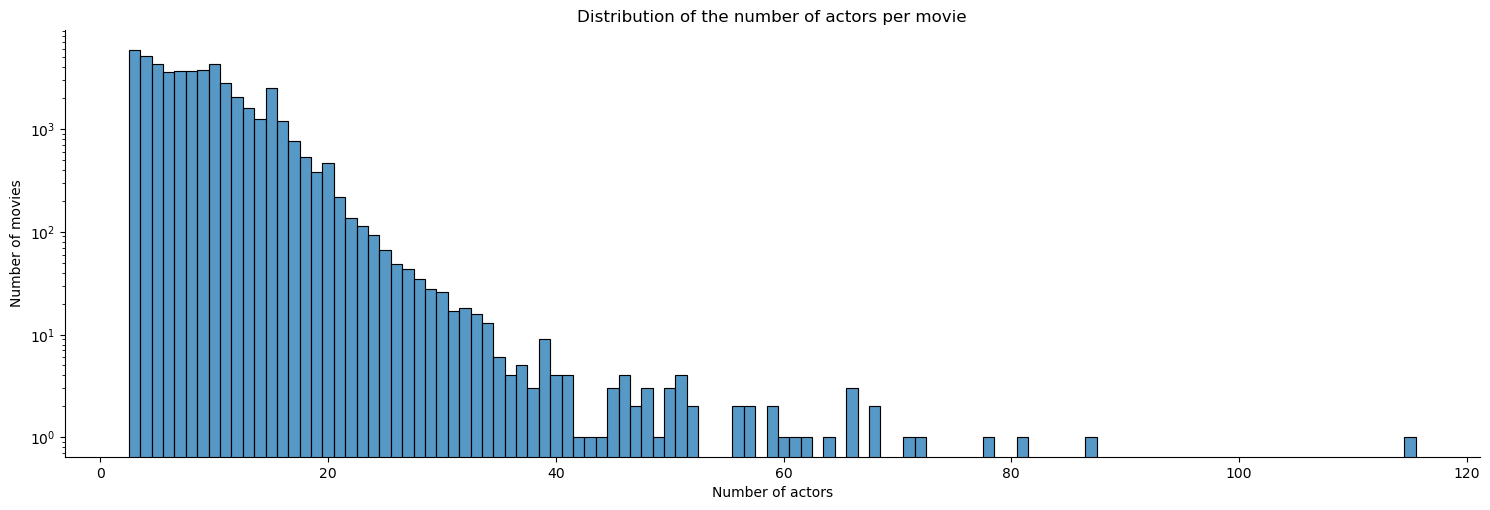

In [32]:
plot = sns.displot(actors['Wikipedia_movie_ID'], x = actors['Number_of_actors'],
                   log=True, discrete=True, aspect = 3)
plot = plot.set(title = 'Distribution of the number of actors per movie', 
               xlabel = 'Number of actors',
               ylabel = 'Number of movies')

# 3. Creating a network of actors

It's now time to creat a first network

## 3.1 Processing the data

In [33]:
# one actor per line in the new dataframe
actors_new_meta = actors.merge(character_metadata[['Character_name', 'Actor_name', 'Wikipedia_movie_ID']], on='Wikipedia_movie_ID', how='inner')

In [34]:
actors_new_meta.sample(3)

,Wikipedia_movie_ID,Actors_names,Number_of_actors,Character_name,Actor_name
358794,26551722,"[Felix Aylmer, Hugh Miller, Stanley Holloway]",3,NaN,Hugh Miller
114486,3943033,"[Catherine Campbell, Travis Barkley, Christoph...",7,NaN,Rachel Stephens
159029,6594677,"[John Getz, Danny Aiello, Michael Biehn, Anne ...",14,NaN,Mary Joy


In [35]:
# dataframe with pairs of actors and the number of movies they acted in together
# the dataframe to merge contains all the actors_new_meta dataframe except the actors_names column
to_merge = actors_new_meta.drop('Actors_names', axis=1)
actors_pairs = to_merge.merge(to_merge, on=['Wikipedia_movie_ID', 'Number_of_actors'], how='inner')
# filter the dataframe to keep only the pairs where the actor names are different
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] != actors_pairs['Actor_name_y']]
# filter the dataframe to keep only the pairs that are not interchangeable (actor1, actor2) and (actor2, actor1)
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] < actors_pairs['Actor_name_y']]

In [36]:
# for each pair make a new column with the list of movies they acted in together
actors_pairs_common_movies = actors_pairs.groupby(['Actor_name_x', 'Actor_name_y'])['Wikipedia_movie_ID'].apply(list).reset_index().rename(columns={'Wikipedia_movie_ID': 'Common_movies'})
# remove the duplicates in the movies list
actors_pairs_common_movies['Common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: list(set(x)))

In [37]:
# number of common movies between each pair of actors
actors_pairs_common_movies['Number_of_common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: len(x))

In [38]:
# filter the dataframe to keep only the pairs that acted in more than 2 movies together
actors_pairs_common_movies_filtered = actors_pairs_common_movies[actors_pairs_common_movies['Number_of_common_movies'] > 2]

In [39]:
actors_pairs_common_movies_filtered.sample(3)

,Actor_name_x,Actor_name_y,Common_movies,Number_of_common_movies
1300436,Jackie Cooper,Sarah Douglas,"[1059280, 5700623, 362719]",3
574554,Charlotte Burton,Sydney Ayres,"[7412453, 7385574, 7323910, 7440006, 7422352, ...",10
1344543,Jane Lynch,John Michael Higgins,"[2873368, 499810, 587507, 9264215]",4


## 3.2 Creating the network

There are many ways to create networks, a really common one is the networkx library. It offers lots of tools and we can easily find documentation on the web.

In [40]:
# create a non directed graph from the dataframe
G = nx.from_pandas_edgelist(actors_pairs_common_movies_filtered, source='Actor_name_x', target='Actor_name_y', edge_attr='Number_of_common_movies')
# show the number of nodes and edges in the graph
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  8418
Number of edges:  25900


Now that we have the network we'll need to analyse it. The first step is to create subgroup using the louvain algorithm.

In [41]:
# make partitions of the graph 
coms = algorithms.louvain(G, weight='Number_of_common_movies')

# make subgraphs from the partitions
subgraphs = [G.subgraph(c) for c in coms.communities]
# show the number of subgraphs
print('Number of communities: ', len(subgraphs))

Number of communities:  638


In [42]:
# show the number of nodes in each subgraph and the average weight of the edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print('community ', i + 1, ' number of actors: ', subgraph.number_of_nodes())
    print('community ', i + 1, ' average numbers of movies between actors: ', subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_edges())

community  1  number of actors:  1105
community  1  average numbers of movies between actors:  3.557619248628113
community  2  number of actors:  1044
community  2  average numbers of movies between actors:  3.6629593810444874
community  3  number of actors:  719
community  3  average numbers of movies between actors:  4.475798737325426
community  4  number of actors:  584
community  4  average numbers of movies between actors:  3.7079847908745247
community  5  number of actors:  363
community  5  average numbers of movies between actors:  4.9363327674023765
community  6  number of actors:  317
community  6  average numbers of movies between actors:  4.627197039777983
community  7  number of actors:  286
community  7  average numbers of movies between actors:  3.633147113594041
community  8  number of actors:  274
community  8  average numbers of movies between actors:  3.9496296296296296
community  9  number of actors:  189
community  9  average numbers of movies between actors:  4.08

## 3.3 Vizualising the network

Let's start the funny part with a basic visualization.

KeyboardInterrupt: 

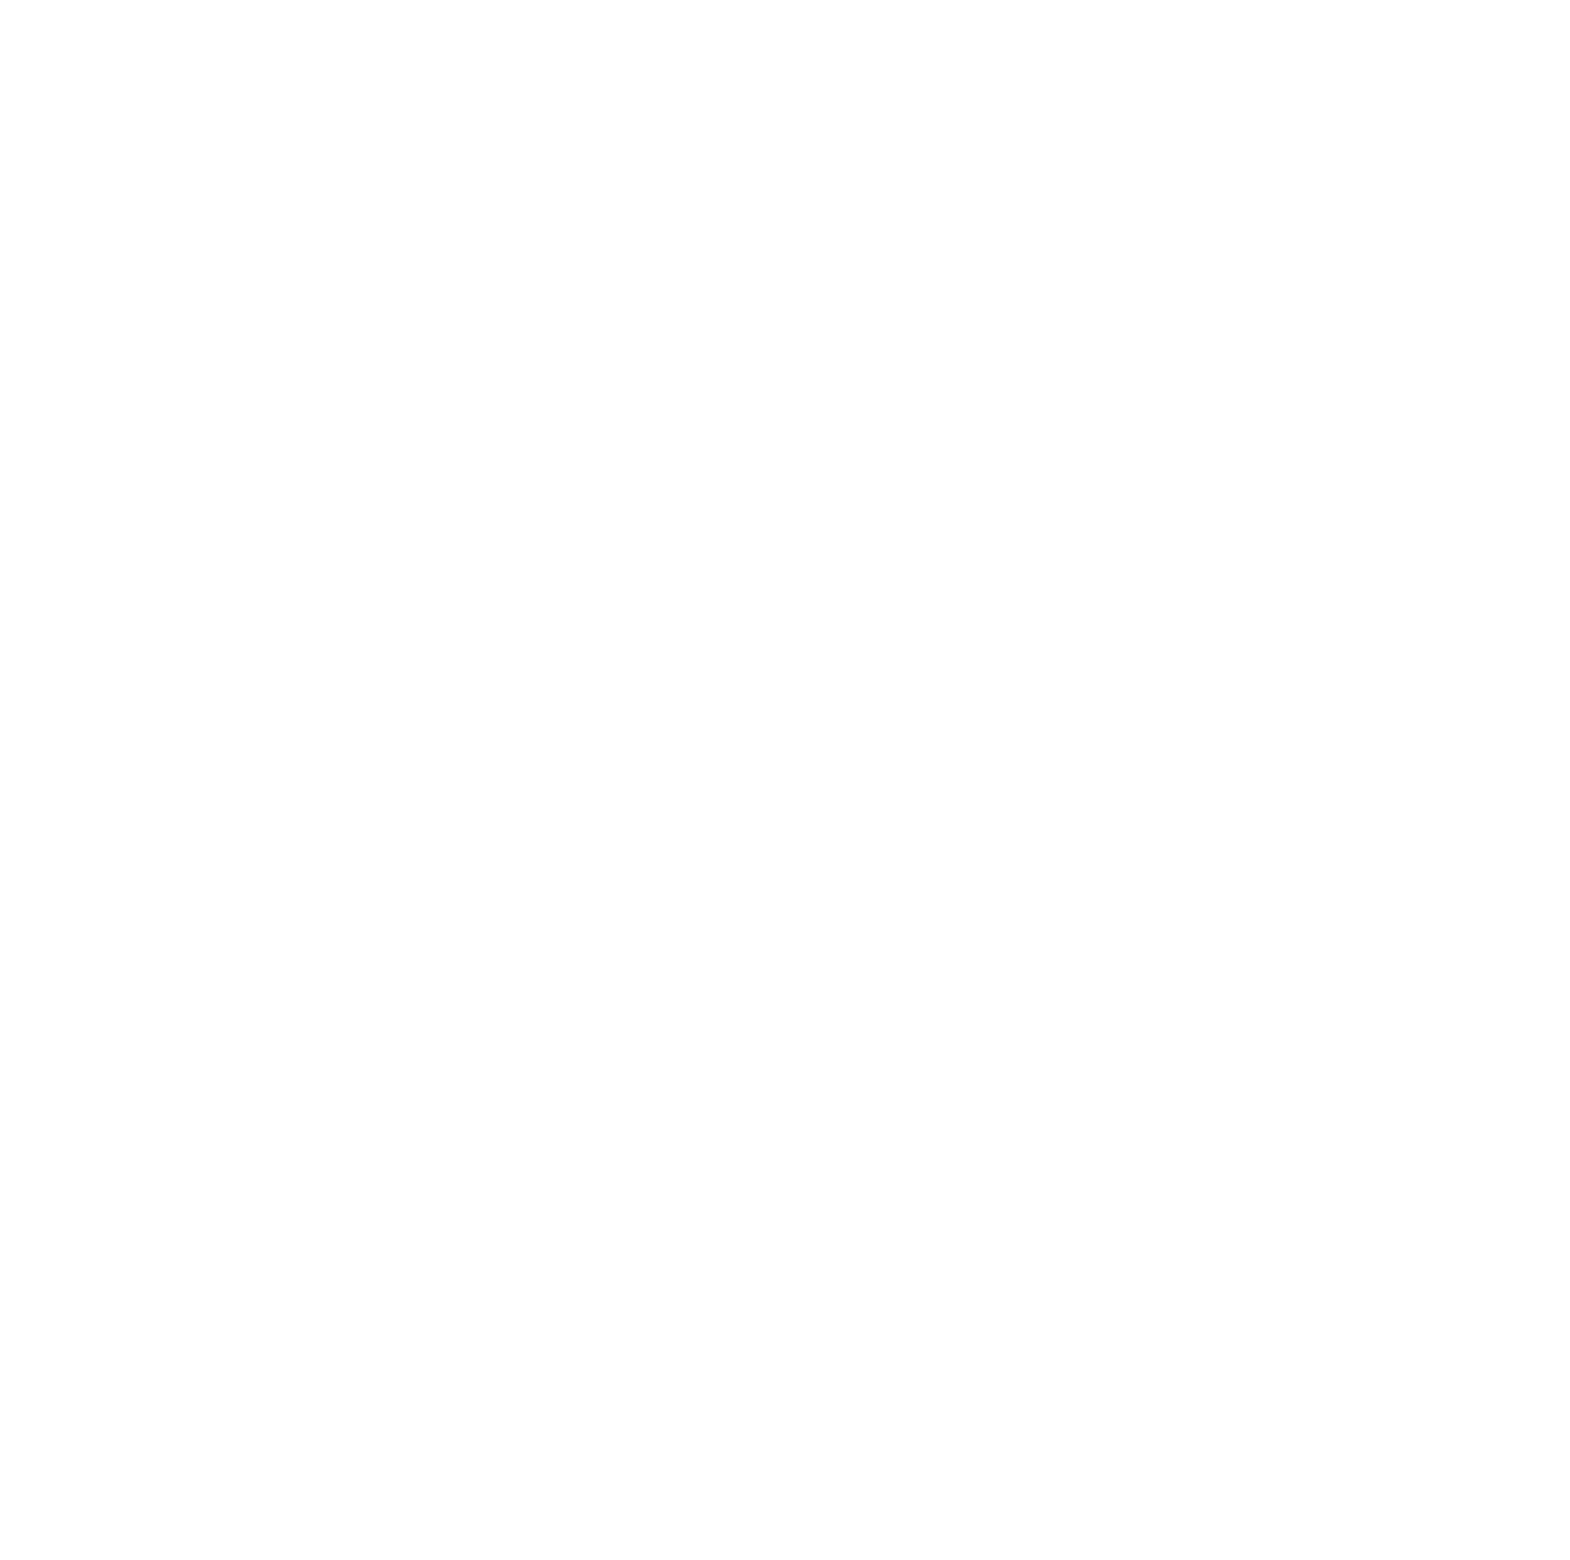

In [43]:
# vizualise the obtained partitions (top 20 communities)
viz.plot_network_clusters(G, coms, node_size=20, figsize=(20, 20), plot_labels=False, top_k=20)

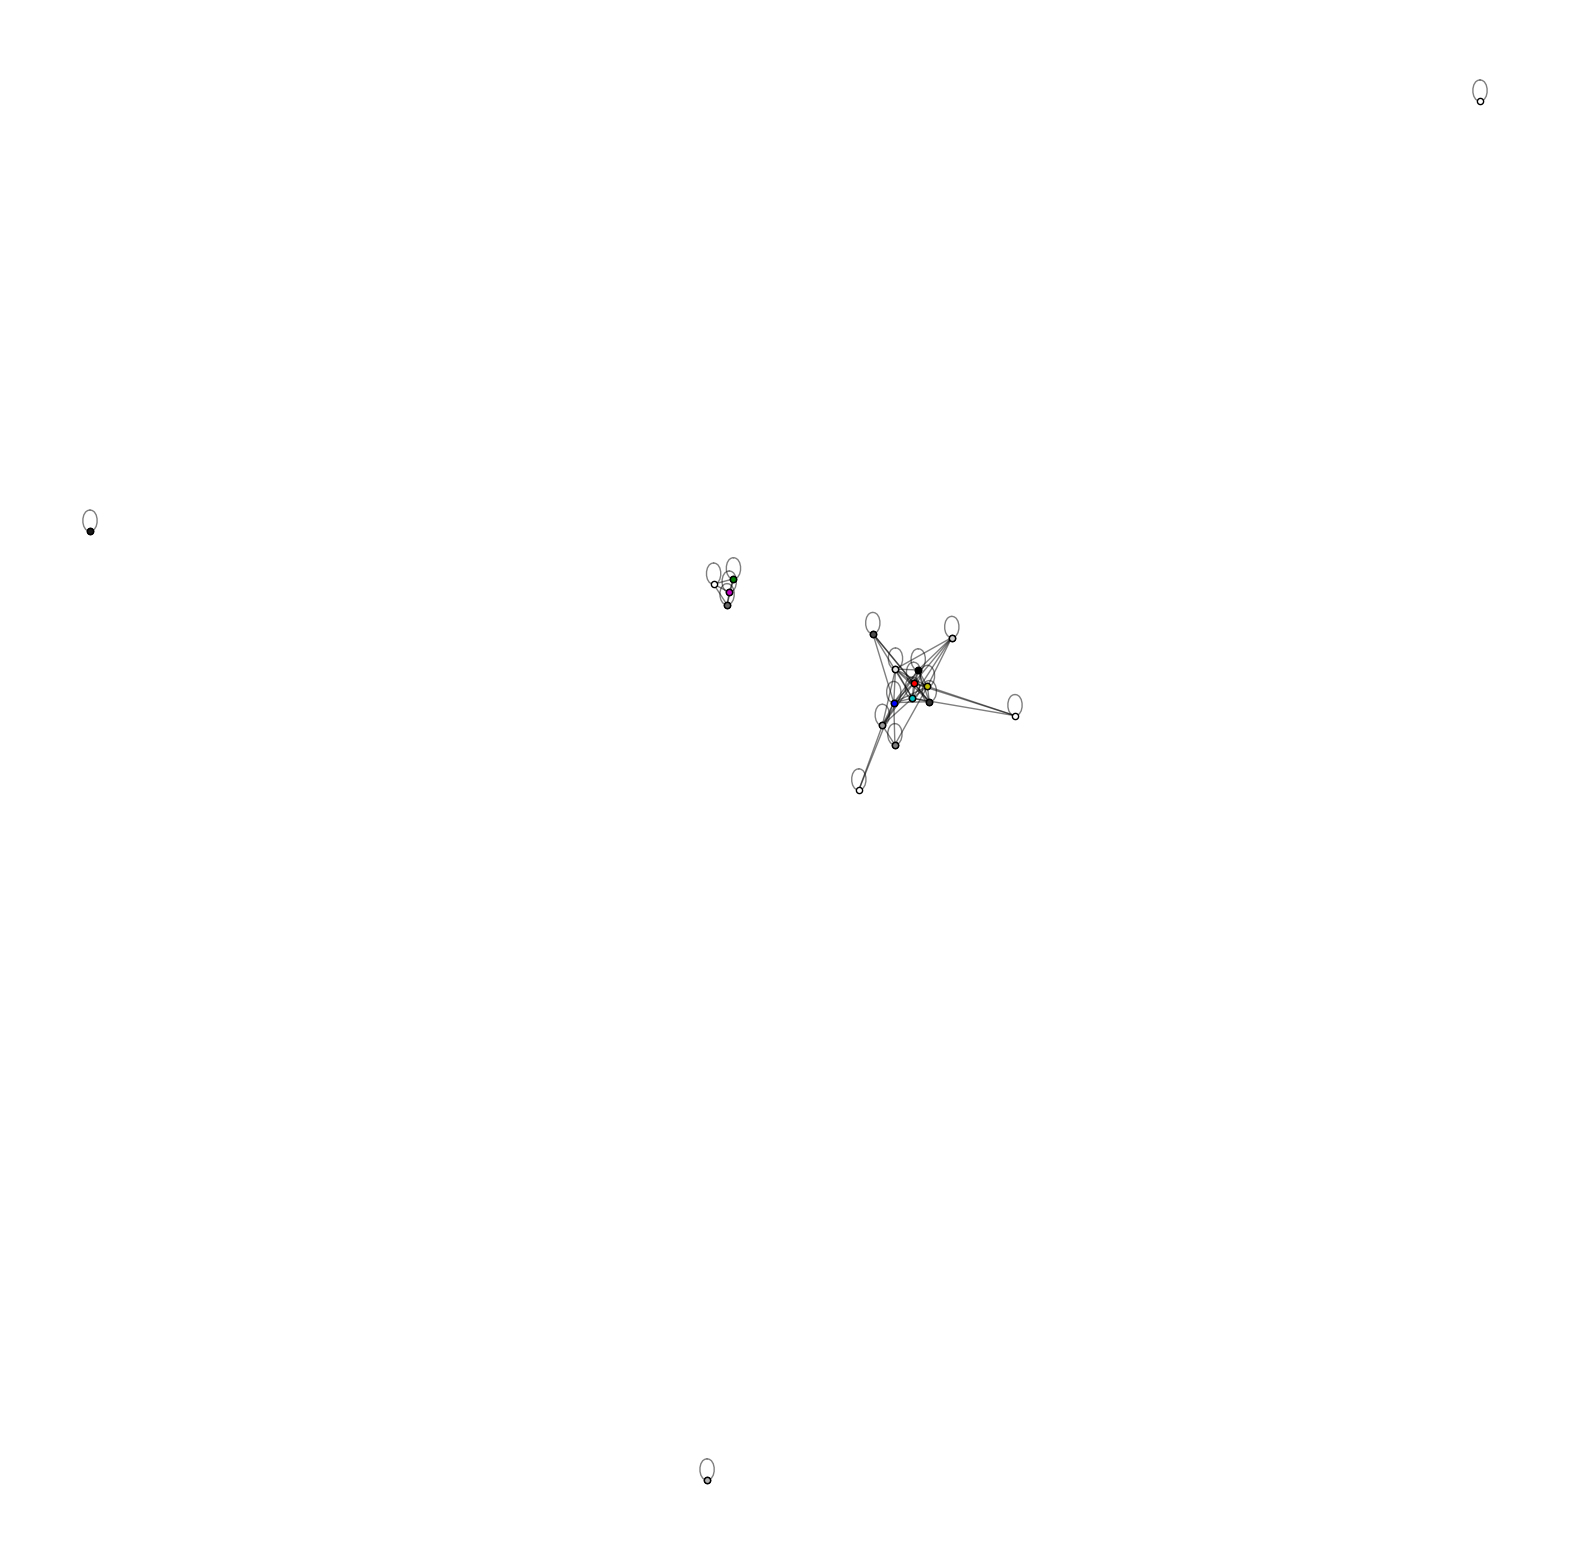

In [44]:
viz.plot_community_graph(G, coms, node_size=20, figsize=(20, 20), plot_labels=False, top_k=20)

## 3.4 Analysing subnetworks

If we aim to see tendencies between those subgroup, we'll need to add features to nodes.

In [45]:
for n in G.nodes:
    G.nodes[n]['actor_gender'] = character_metadata[character_metadata.Actor_name == n]['actor_gender'].iloc[0]
    G.nodes[n]['Actor_ethnicity'] = character_metadata[character_metadata.Actor_name == n]['Actor_ethnicity'].iloc[0]

KeyboardInterrupt: 

We can now compute the assortativity  for certains properties. It measures the similarity of connections in the graph with respect to the given attribute.

In [ ]:
print("gender homophily: ", nx.attribute_assortativity_coefficient(G, 'actor_gender'))
print("ethnicity homophily: ", nx.attribute_assortativity_coefficient(G, 'Actor_ethnicity'))

In [ ]:
# store the top 20 communities in dataframes
# each row in the dataframe is an actor in the community, the connectivity column represents the total weight of the edges that the actor is connected to
# i.e the total number of movies the actor acted in with the other actors in the community
top_20_communities = []
for i, subgraph in enumerate(subgraphs[:20]):
    top_20_communities.append(pd.DataFrame(subgraph.degree(weight='Number_of_common_movies'), columns=['Actor_name', 'connectivity']).sort_values('connectivity', ascending=False))

In [ ]:
# for each community add columns for actors ethnicity, gender and date of birth from the character_metadata dataframe
for i, community in enumerate(top_20_communities):
    top_20_communities[i] = community.merge(character_metadata[['Actor_name','actor_gender', 'Actor_date_of_birth', 'Actor_ethnicity']], on='Actor_name', how='inner').drop_duplicates(subset=['Actor_name']).reset_index(drop=True)


In [46]:
G = nx.connected_watts_strogatz_graph(30,5,.2)
nodes = G.nodes()
edges=list(G.edges(data=True))

Additionnally from observing actors in each communities, we would like to include in our communities' analysis the movies within each community, i.e. the movies that connect actors together within a single community. For this purpose, we start by mapping movies' occurencies for each community. 
Later on, we can use this table to analyze the number of movies within each community, whether a movie appears in only one, or several communities, and also add movies features such as genre, length or date of release. 

In [56]:
movies_com_list = pd.DataFrame(columns = ['movie_index','community'])

# first we extract for each edge in a subgraph the corresponding movies and store in a dataframe the movie index and the community
for community_nb in range(1,21):
    for x in subgraphs[community_nb].edges:
        movies = actors_pairs_common_movies_filtered.loc[   (actors_pairs_common_movies_filtered['Actor_name_x'] == x[0])
                                                        & (actors_pairs_common_movies_filtered['Actor_name_y'] == x[1])].Common_movies
        if len(movies)==0:
            movies = actors_pairs_common_movies_filtered.loc[   (actors_pairs_common_movies_filtered['Actor_name_x'] == x[1])
                                                            &  (actors_pairs_common_movies_filtered['Actor_name_y'] == x[0])].Common_movies
        if len(movies)==0:
            print('error')
        for list in movies:
            for elt in list:
                movies_com_list = movies_com_list.append(pd.DataFrame([[int(elt),int(community_nb)]], columns=['movie_index','community']),ignore_index = True) 

# data rearranged to have each movie as a row, and each community as a column. the value describes the numbers of edges referring to a movie within the specified community
movie_com_table = movies_com_list.pivot_table( columns='community', index='movie_index', aggfunc=len,fill_value=0)
movie_com_table.to_csv('movies_communities_table.csv')

In [61]:
movie_com_table

community,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
movie_index,,,,,,,,,,,,,,,,,,,,
3333,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3837,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0
4560,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4726,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4728,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36657306,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36806453,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37302868,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [65]:
# Aggregate this information with the features of each movie 
movies_com_metadata = pd.merge(movies_metadata, movie_com_table, left_on = 'Wikipedia_movie_ID',right_on = 'movie_index')
movies_com_metadata.to_csv('movies_communities_metadata.csv')
#we still need to clean the Movie_languages, Movie_countries and Movie_genre ? 